### IMPORTING REQUIRED LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import math
import cv2
import os
import re
from PIL import Image, ImageTk

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model

import tkinter as tk
from tkinter import filedialog

In [2]:
# Storing the paths to image data
training_images_path = "data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
validation_images_path = "data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
test_images_path= "data/test/test/"

In [3]:
# Filtering out .DS_Store which is an automatically generated directory and print only the classes which contain plant image data in TRAINING SET FOLDER
class_names_train = [name for name in os.listdir(training_images_path) if name != '.DS_Store' and os.path.isdir(os.path.join(training_images_path, name))]

print("Number of classes : {}" . format(len(class_names_train)))
class_names_train

Number of classes : 9


['Grape_Esca',
 'Grape_Healthy',
 'Cherry_Powdery_Mildew',
 'Grape_Black_Rot',
 'Cherry_Healthy',
 'Strawberry_Leaf_Scorch',
 'Peach_Bacterial_Spot',
 'Strawberry_Healthy',
 'Peach_Healthy']

In [4]:
# Filtering out .DS_Store which is an automatically generated directory and print only the classes which contain plant image data in VALIDATION SET FOLDER
class_names_validate = [name for name in os.listdir(validation_images_path) if name != '.DS_Store' and os.path.isdir(os.path.join(validation_images_path, name))]

print("Number of classes : {}" . format(len(class_names_validate)))
class_names_validate

Number of classes : 9


['Grape_Esca',
 'Grape_Healthy',
 'Cherry_Powdery_Mildew',
 'Grape_Black_Rot',
 'Cherry_Healthy',
 'Strawberry_Leaf_Scorch',
 'Peach_Bacterial_Spot',
 'Strawberry_Healthy',
 'Peach_Healthy']

### PRE-PROCESSING THE DATA

In [5]:
def create_data_frame(path):
    # Initializing empty lists to store the extracted data
    list_plant=[]
    list_category=[]
    list_disease=[]
    list_path=[]
    list_plant_category=[]
    list_image_size=[]
    list_image_type=[]
    list_size=[]
    
    # Recursively walking through the directory tree, iterating over each file in the directory
    for path, directory, files in os.walk(path, topdown=False):
        for name in files:
            if not name.startswith('.'): 
                plant_category = path.split("/")[-1]
                plant = plant_category.split('_')[0]
                category = '_'.join(plant_category.split('_')[1:])  # Join back the rest of the split if more than two parts

                disease = 0 if "Healthy" in category else 1
                full_path = os.path.join(path, name)

                # Getting the image file type (extension)
                image_type = name.split(".")[-1]
                size = os.path.getsize(full_path)

                # Opening the image and get dimensions
                with Image.open(full_path) as images:
                    width, height = images.size

                # Appending all info to lists
                list_plant.append(plant)
                list_category.append(category)
                list_disease.append(disease)
                list_path.append(full_path)
                list_plant_category.append(plant_category)
                list_image_size.append(f"{width}x{height}")
                list_image_type.append(image_type)
                list_size.append(size)

    # Creating a DataFrame
    data_info = pd.DataFrame({
        "Plant": list_plant,
        "Category": list_category,
        "Disease": list_disease,
        "Path": list_path,
        "Plant_Category": list_plant_category,
        "Image_size": list_image_size,
        "Image_type": list_image_type,
        "Size": list_size
    })
    
    # Creating a summary DataFrame
    image_count_info = pd.DataFrame(data_info.groupby(["Plant", "Category", "Plant_Category"]).size(), columns=['nb']).reset_index()
    
    return data_info, image_count_info

# Calling the create_data_frame function for the training and validation data
train_data_info,train_data_count=create_data_frame(training_images_path)
valid_data_info,valid_data_count=create_data_frame(validation_images_path)

In [6]:
# Setting the image dimensions
img_width, img_height = 256, 256

# Defining ImageDataGenerators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Connecting the ImageDataGenerator objects to the dataset folders
train_generator = train_datagen.flow_from_directory(
    training_images_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    validation_images_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 4491 images belonging to 9 classes.
Found 981 images belonging to 9 classes.


### DATA ANALYSIS AND VISUALIZATION

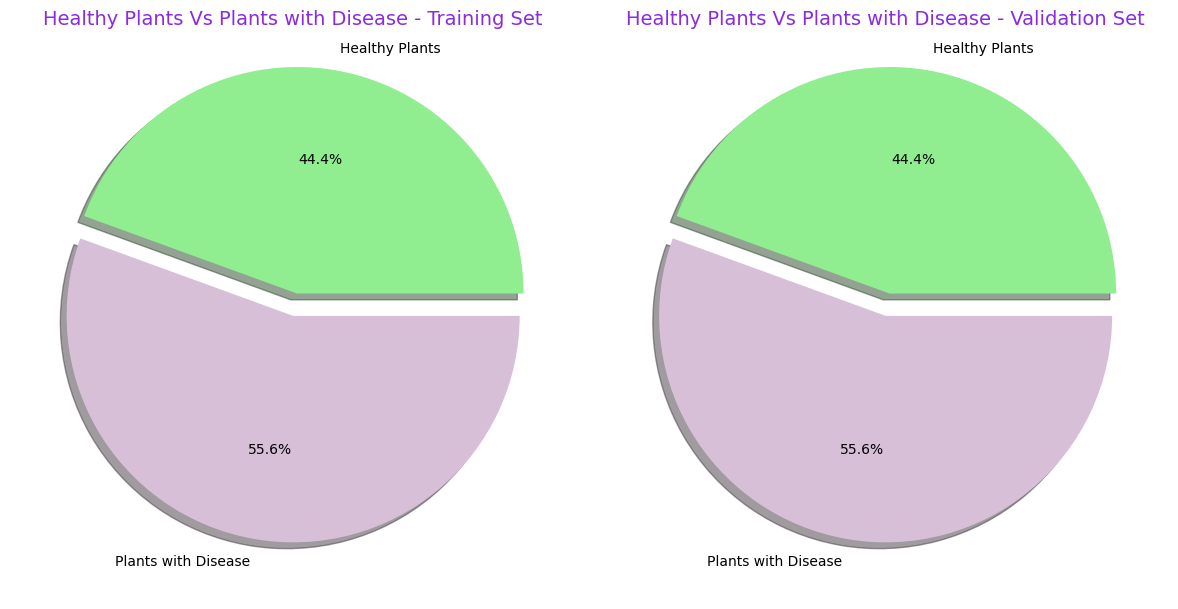

In [ ]:
# Creating pie plots tocheck data dirtribution of healthy and disease classes
plt.figure(figsize=(12, 6))

# First subplot for the training set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.title("Healthy Plants Vs Plants with Disease - Training Set", fontsize=14, color="blueviolet")
plt.pie(
    [
        train_data_count.nb[train_data_count.Category == "Healthy"].sum(),
        train_data_count.nb[train_data_count.Category != "Healthy"].sum()
    ],
    labels=["Healthy Plants", "Plants with Disease"],
    autopct='%1.1f%%',  
    colors=["lightgreen", "thistle"],
    shadow=True,
    explode=(0.10, 0)
)

# Second subplot for the validation set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.title("Healthy Plants Vs Plants with Disease - Validation Set", fontsize=14, color="blueviolet")
plt.pie(
    [
        valid_data_count.nb[valid_data_count.Category == "Healthy"].sum(),
        valid_data_count.nb[valid_data_count.Category != "Healthy"].sum()
    ],
    labels=["Healthy Plants", "Plants with Disease"],
    autopct='%1.1f%%', 
    colors=["lightgreen", "thistle"],
    shadow=True,
    explode=(0.10, 0)
)

# Displaying the plots
plt.tight_layout()  
plt.show()

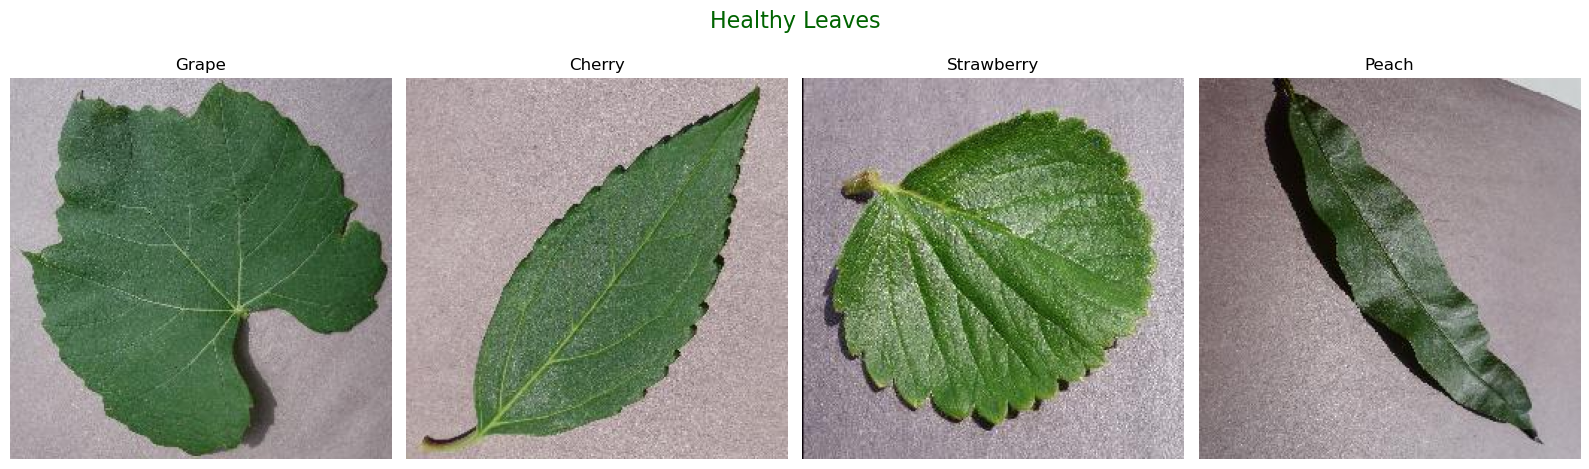

In [11]:
# Getting list of directories, filtering out .DS_Store and ensuring only directories are included
directories = [d for d in os.listdir(training_images_path) if d != '.DS_Store' and os.path.isdir(os.path.join(training_images_path, d))]

# Splitting the directories into 'healthy' and 'diseased'
healthy_dirs = [d for d in directories if 'healthy' in d.lower()]

# Function to plot images given a list of directories
def plot_images(dirs, title, rows, cols):
    plt.figure(figsize=(16, 5))  
    plt.suptitle(title, fontsize=16, color="darkgreen")  
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    for i, directory in enumerate(dirs):
        # Only proceed if we have not exceeded the rows*cols limit
        if i < rows*cols:
            random_folder_path = os.path.join(training_images_path, directory)
            images = [img for img in os.listdir(random_folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if not images:
                continue

            random_image = np.random.choice(images)
            random_image_path = os.path.join(random_folder_path, random_image)
            image = cv2.imread(random_image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(image)
            plt.axis("off")

            # Getting plot title from directory name
            plt.title(directory.split('_')[0], fontsize=12)  

    plt.tight_layout()
    plt.show()

#  Using the function to plot healthy and diseased images separately
plot_images(healthy_dirs, 'Healthy Leaves', 1, 4)  


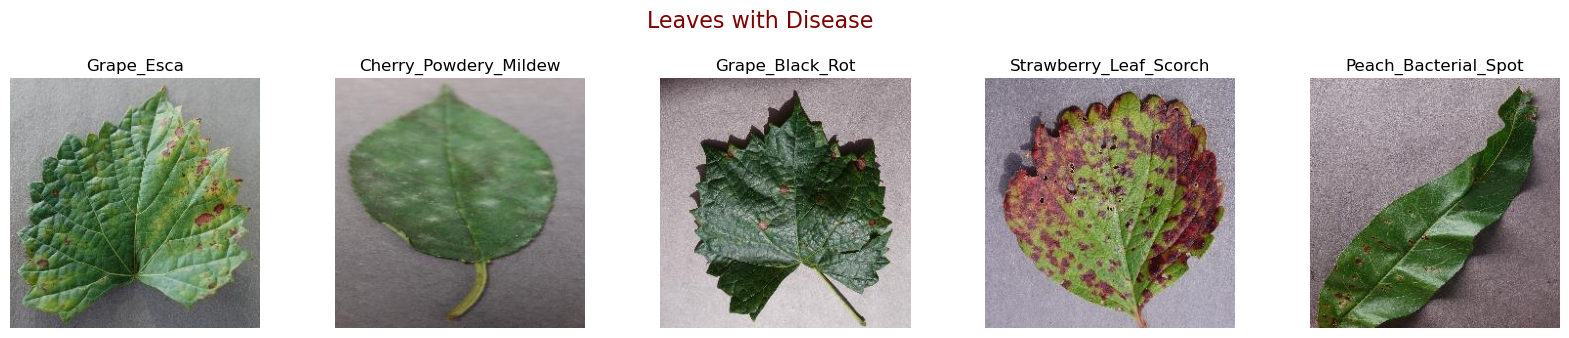

In [12]:
# Plotting all the unhealthy plant leaf images
not_healthy_dirs = [d for d in directories if 'healthy' not in d.lower()]

plt.figure(figsize=(20, 4))  
plt.subplots_adjust(wspace=0.3, hspace=0.3)  
plt.suptitle("Leaves with Disease", fontsize=16, color="maroon")

for i in range(5):  
    if i < len(not_healthy_dirs):  
        directory = not_healthy_dirs[i]
        
        random_folder_path = os.path.join(training_images_path, directory)

        # Getting a list of images in the chosen directory, filtering for image files
        images = [img for img in os.listdir(random_folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not images:
            continue  # Skipping directories without images

        # Selecting a random image from the list
        random_image = np.random.choice(images)
        random_image_path = os.path.join(random_folder_path, random_image)
        
        # Reading and converting the image from BGR to RGB
        image = cv2.imread(random_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Displaying the image
        plt.subplot(1, 5, i + 1)  
        plt.imshow(image)
        plt.axis("off")
        plt.title(directory)

plt.show()

In [13]:
# Checking number of images in all classes of training dataset
num_images={}
for class_name in class_names_train:
    num_images[class_name] = len(os.listdir(training_images_path+"/"+class_name))
images_each_class = pd.DataFrame(num_images.values(),index = num_images.keys(),columns = ["Number of images"])
images_each_class

,Number of images
Grape_Esca,500
Grape_Healthy,500
Cherry_Powdery_Mildew,500
Grape_Black_Rot,500
Cherry_Healthy,500
Strawberry_Leaf_Scorch,500
Peach_Bacterial_Spot,500
Strawberry_Healthy,500
Peach_Healthy,500


In [14]:
# Checking number of images in all classes of validation dataset
num_images_val={}
for class_name in class_names_validate:
    num_images_val[class_name] = len(os.listdir(validation_images_path+"/"+class_name))
images_each_class_val = pd.DataFrame(num_images_val.values(),index = num_images_val.keys(),columns = ["Number of images"])
images_each_class_val

,Number of images
Grape_Esca,110
Grape_Healthy,110
Cherry_Powdery_Mildew,110
Grape_Black_Rot,110
Cherry_Healthy,110
Strawberry_Leaf_Scorch,110
Peach_Bacterial_Spot,110
Strawberry_Healthy,110
Peach_Healthy,110


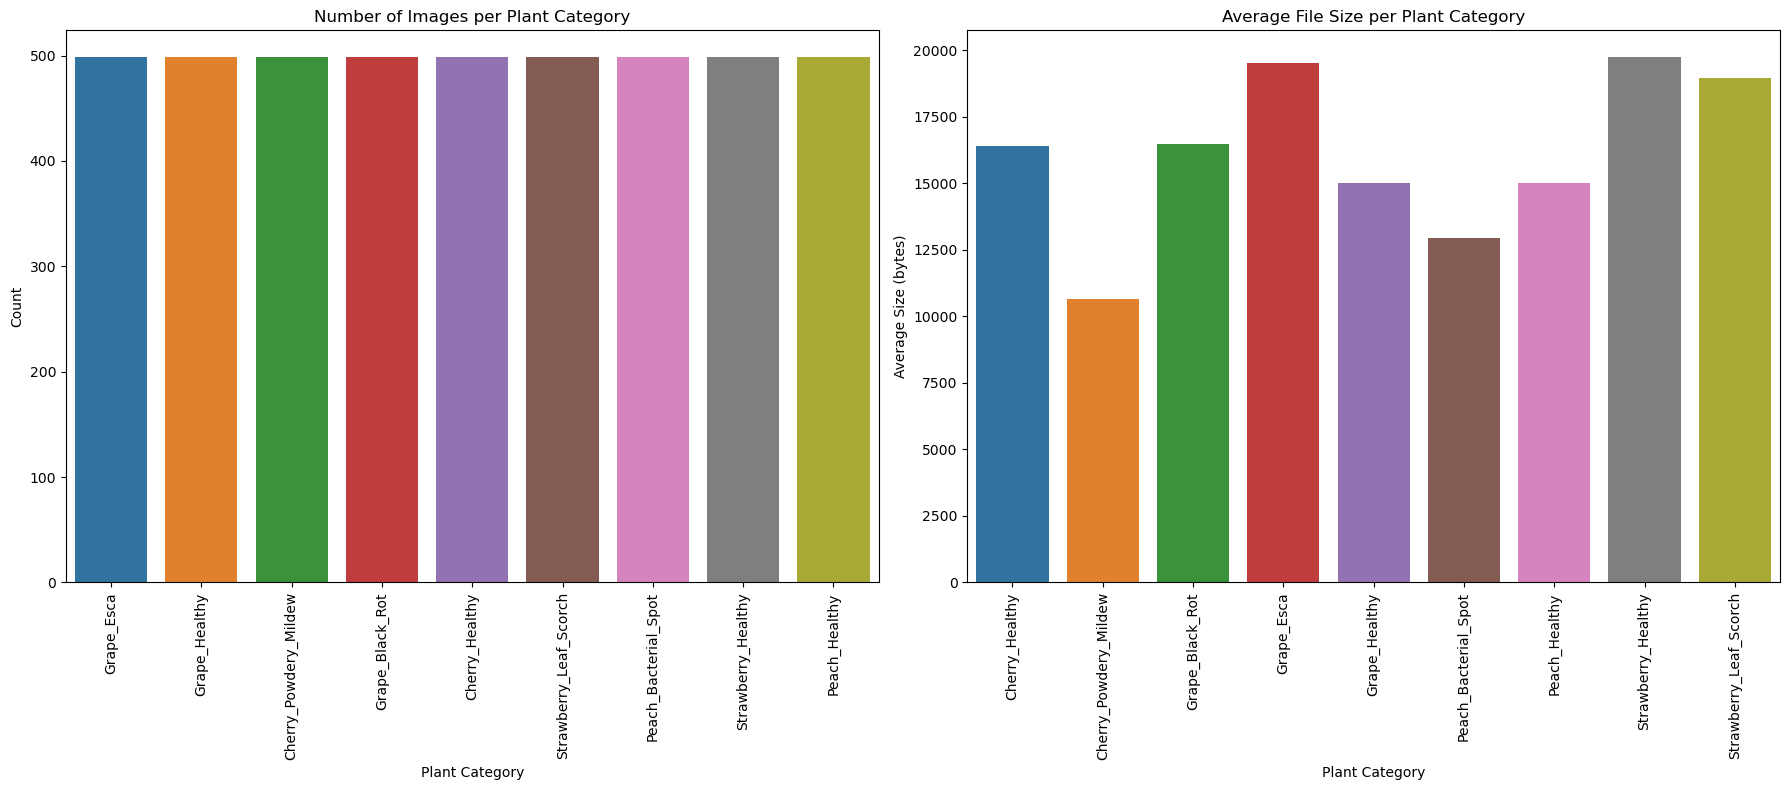

In [15]:
# Creating a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Count of Images per Plant Category
sns.countplot(data=train_data_info, x='Plant_Category', ax=axes[0])
axes[0].set_title('Number of Images per Plant Category')
axes[0].set_xlabel('Plant Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Plot 2: Average File Size per Category
avg_file_size = train_data_info.groupby('Plant_Category')['Size'].mean().reset_index()
sns.barplot(data=avg_file_size, x='Plant_Category', y='Size', ax=axes[1])
axes[1].set_title('Average File Size per Plant Category')
axes[1].set_xlabel('Plant Category')
axes[1].set_ylabel('Average Size (bytes)')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()  
plt.show()

### PREPARING TEST DATA

In [16]:
# Creating a mapping from class names to numerical indices based on 'train_generator'
class_indices = train_generator.class_indices 
class_indices

{'Cherry_Healthy': 0,
 'Cherry_Powdery_Mildew': 1,
 'Grape_Black_Rot': 2,
 'Grape_Esca': 3,
 'Grape_Healthy': 4,
 'Peach_Bacterial_Spot': 5,
 'Peach_Healthy': 6,
 'Strawberry_Healthy': 7,
 'Strawberry_Leaf_Scorch': 8}

In [17]:
# Reverse mapping to translate predictions
index_to_class = {v: k for k, v in class_indices.items()}  

# Function to map class name to index
def get_class_index(class_name):
    return class_indices.get(class_name, -1)  # Returns -1 if class_name is not found

In [18]:
# Listing all image files in the directory
image_files = [f for f in os.listdir(test_images_path) if f.lower().endswith('.jpg')]
# Ensure there's no hidden files like .DS_Store
image_files = [f for f in image_files if not f.startswith('.')]

# Creating a DataFrame with filenames and the corresponding class labels
test_df = pd.DataFrame({
    'filename': image_files
})

test_df

,filename
0,Cherry_Powdery_Mildew3.JPG
1,Peach_Bacterial_Spot3.JPG
2,Grape_Esca9.JPG
3,Grape_Esca8.JPG
4,Peach_Bacterial_Spot2.JPG
...,...
85,Strawberry_Leaf_Scorch6.JPG
86,Grape_Esca5.JPG
87,Grape_Esca4.JPG
88,Strawberry_Leaf_Scorch7.JPG


In [19]:
# Function to extract class labels from filenames (e.g., Peach_Bacterial_Spot3, Cherry_Healthy1)
def extract_label_from_filename(filename):
    # Removing any trailing digits and the extension, then return the remainder
    return re.sub(r'\d+\.\w+$', '', filename)  # Removes trailing digits and file extension

test_df['true_label'] = test_df['filename'].apply(extract_label_from_filename)

In [20]:
# Setting up test data generator without labels
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_images_path,
    x_col='filename',
    y_col=None,
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 90 validated image filenames.


### IMPLEMENTING OWN MODEL

### CNN MODEL

In [21]:
# Defining the model architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')  
])

cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

# Summarizing the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [22]:
# Training the model
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/10
140/140 [==============================] - 61s 434ms/step - loss: 1.5305 - accuracy: 0.6257 - val_loss: 0.4758 - val_accuracy: 0.8406
Epoch 2/10
140/140 [==============================] - 67s 474ms/step - loss: 0.3851 - accuracy: 0.8693 - val_loss: 0.5699 - val_accuracy: 0.8469
Epoch 3/10
140/140 [==============================] - 71s 502ms/step - loss: 0.2508 - accuracy: 0.9116 - val_loss: 0.2386 - val_accuracy: 0.9281
Epoch 4/10
140/140 [==============================] - 68s 482ms/step - loss: 0.2181 - accuracy: 0.9237 - val_loss: 0.3803 - val_accuracy: 0.9062
Epoch 5/10
140/140 [==============================] - 70s 500ms/step - loss: 0.1498 - accuracy: 0.9480 - val_loss: 0.4039 - val_accuracy: 0.9010
Epoch 6/10
140/140 [==============================] - 63s 445ms/step - loss: 0.1467 - accuracy: 0.9473 - val_loss: 0.3880 - val_accuracy: 0.8917
Epoch 7/10
140/140 [==============================] - 61s 432ms/step - loss: 0.1323 - accuracy: 0.9547 - val_loss: 0.3584 - val_ac

In [48]:
# Saving the model
cnn_model.save('cnn_plant_disease_classifier.h5')

/Users/omishan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


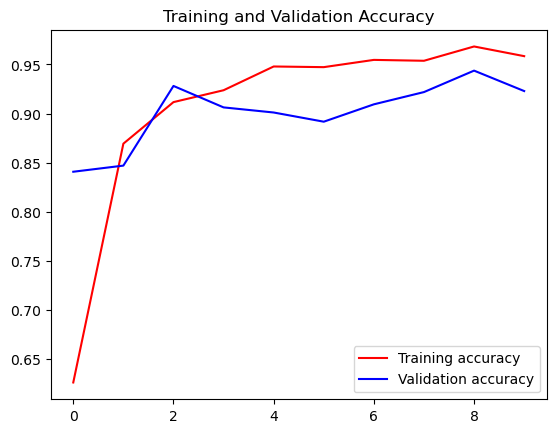

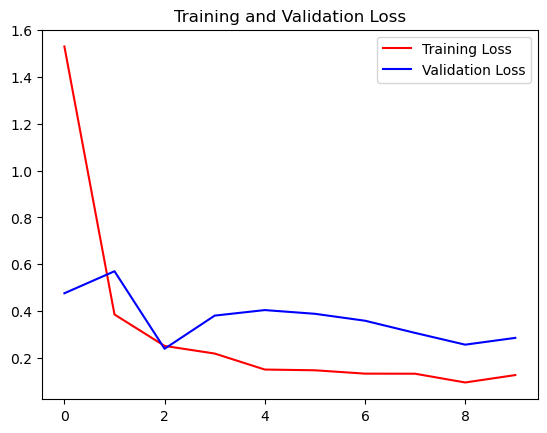

In [24]:
#Plotting accuracies
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [35]:
# Getting the index of the last epoch
last_epoch = len(history_cnn.history['accuracy']) - 1

# Print the final training and validation accuracies in percentage
print(f"Final Training Accuracy: {history_cnn.history['accuracy'][last_epoch] * 100:.2f}%")
print(f"Final Validation Accuracy: {history_cnn.history['val_accuracy'][last_epoch] * 100:.2f}%")

Final Training Accuracy: 95.85%
Final Validation Accuracy: 92.29%


In [25]:
# Predicting class indices using the model
predictions = cnn_model.predict(test_generator, steps=np.ceil(len(test_df) / 32))
predicted_indices = np.argmax(predictions, axis=1)

3/3 [==============================] - 0s 95ms/step


In [27]:
# Mapping predicted indices back to class names
predicted_class_names = [index_to_class.get(idx, "Unknown") for idx in predicted_indices]
test_df['predicted_class'] = predicted_class_names

In [28]:
# Calculating accuracy
accuracy_cnn = accuracy_score(test_df['true_label'], test_df['predicted_class'])
print(f"Testing Accuracy: {accuracy_cnn * 100:.2f}%")

Testing Accuracy: 83.33%


In [29]:
# Mapping predicted indices back to class names
predicted_class_names = [index_to_class.get(idx, "Unknown") for idx in predicted_indices]
test_df['predicted_class'] = predicted_class_names

In [32]:
# Displaying a sample of the data
print("Predicted v/s Actual Labels- \n", test_df[['filename', 'true_label', 'predicted_class']].sample(10))

Predicted v/s Actual Labels- 
                       filename             true_label        predicted_class
72   Peach_Bacterial_Spot8.JPG   Peach_Bacterial_Spot   Peach_Bacterial_Spot
86             Grape_Esca5.JPG             Grape_Esca             Grape_Esca
74          Peach_Healthy1.JPG          Peach_Healthy          Peach_Healthy
21  Cherry_Powdery_Mildew7.JPG  Cherry_Powdery_Mildew  Cherry_Powdery_Mildew
31          Grape_Healthy6.JPG          Grape_Healthy          Grape_Healthy
82         Cherry_Heathy10.JPG          Cherry_Heathy         Cherry_Healthy
41     Strawberry_Healthy9.JPG     Strawberry_Healthy     Strawberry_Healthy
40          Cherry_Heathy3.JPG          Cherry_Heathy         Cherry_Healthy
23          Grape_Healthy5.JPG          Grape_Healthy          Grape_Healthy
57     Strawberry_Healthy3.JPG     Strawberry_Healthy     Strawberry_Healthy


### TRANSFER LEARNING using MobileNetV2

In [33]:
# Assuming img_height and img_width are defined elsewhere in your script
input_shape = (img_height, img_width, 3)

# Loading the ResNet50 model pre-trained on ImageNet data
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(input_shape))

# Freezing the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Creating the model
tl_model = Sequential([
    base_model,  # ResNet50 pre-trained base
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # Adjust the Dense layer to your number of classes
])

# Compiling the model with the updated learning rate syntax
tl_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Printing the summary of the model to check the configuration
tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 2423113 (9.24 MB)
Trainable params: 1651

In [34]:
# Training the model
history_tl = tl_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/10
140/140 [==============================] - 46s 316ms/step - loss: 1.4704 - accuracy: 0.5086 - val_loss: 0.5917 - val_accuracy: 0.9323
Epoch 2/10
140/140 [==============================] - 43s 307ms/step - loss: 0.5855 - accuracy: 0.8370 - val_loss: 0.2616 - val_accuracy: 0.9729
Epoch 3/10
140/140 [==============================] - 44s 314ms/step - loss: 0.3608 - accuracy: 0.9020 - val_loss: 0.1687 - val_accuracy: 0.9740
Epoch 4/10
140/140 [==============================] - 45s 320ms/step - loss: 0.2566 - accuracy: 0.9318 - val_loss: 0.1214 - val_accuracy: 0.9802
Epoch 5/10
140/140 [==============================] - 42s 302ms/step - loss: 0.2079 - accuracy: 0.9448 - val_loss: 0.1082 - val_accuracy: 0.9729
Epoch 6/10
140/140 [==============================] - 45s 318ms/step - loss: 0.1751 - accuracy: 0.9525 - val_loss: 0.0843 - val_accuracy: 0.9865
Epoch 7/10
140/140 [==============================] - 44s 315ms/step - loss: 0.1492 - accuracy: 0.9596 - val_loss: 0.0708 - val_ac

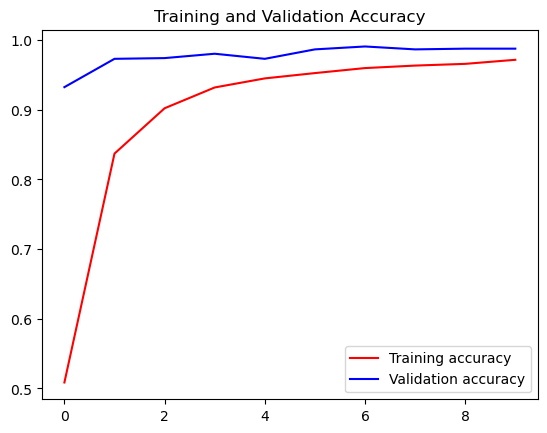

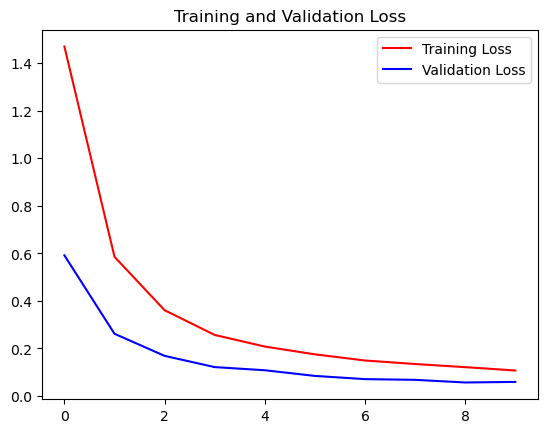

In [37]:
#Plotting accuracies
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']
loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [38]:
# Getting the index of the last epoch
last_epoch = len(history_tl.history['accuracy']) - 1

# Print the final training and validation accuracies in percentage
print(f"Final Training Accuracy: {history_tl.history['accuracy'][last_epoch] * 100:.2f}%")
print(f"Final Validation Accuracy: {history_tl.history['val_accuracy'][last_epoch] * 100:.2f}%")

Final Training Accuracy: 97.15%
Final Validation Accuracy: 98.75%


In [41]:
# Saving the model
tl_model.save('tl_plant_disease_classifier.h5')

In [42]:
# Predicting class indices using the model
predictions = tl_model.predict(test_generator, steps=np.ceil(len(test_df) / 32))
predicted_indices = np.argmax(predictions, axis=1)

3/3 [==============================] - 1s 214ms/step


In [43]:
# Mapping predicted indices back to class names
predicted_class_names = [index_to_class.get(idx, "Unknown") for idx in predicted_indices]
test_df['predicted_class'] = predicted_class_names

In [50]:
# Calculating accuracy
accuracy_tf = accuracy_score(test_df['true_label'], test_df['predicted_class'])
print(f"Testing Accuracy: {accuracy_tf * 100:.2f}%")

Testing Accuracy: 88.89%


In [52]:
# Displaying a sample of the data
print("Predicted v/s Actual Labels- \n", test_df[['filename', 'true_label', 'predicted_class']].sample(10))

Predicted v/s Actual Labels- 
                       filename             true_label        predicted_class
83          Peach_Healthy4.JPG          Peach_Healthy          Peach_Healthy
43          Cherry_Heathy2.JPG          Cherry_Heathy         Cherry_Healthy
51     Strawberry_Healthy5.JPG     Strawberry_Healthy     Strawberry_Healthy
82         Cherry_Heathy10.JPG          Cherry_Heathy         Cherry_Healthy
67  Cherry_Powdery_Mildew9.JPG  Cherry_Powdery_Mildew  Cherry_Powdery_Mildew
38          Grape_Healthy3.JPG          Grape_Healthy          Grape_Healthy
30        Grape_Black_Rot7.JPG        Grape_Black_Rot        Grape_Black_Rot
1    Peach_Bacterial_Spot3.JPG   Peach_Bacterial_Spot   Peach_Bacterial_Spot
79             Grape_Esca6.JPG             Grape_Esca             Grape_Esca
53     Strawberry_Healthy1.JPG     Strawberry_Healthy     Strawberry_Healthy


### CREATING A GUI

1/1 [==============================] - 0s 26ms/step


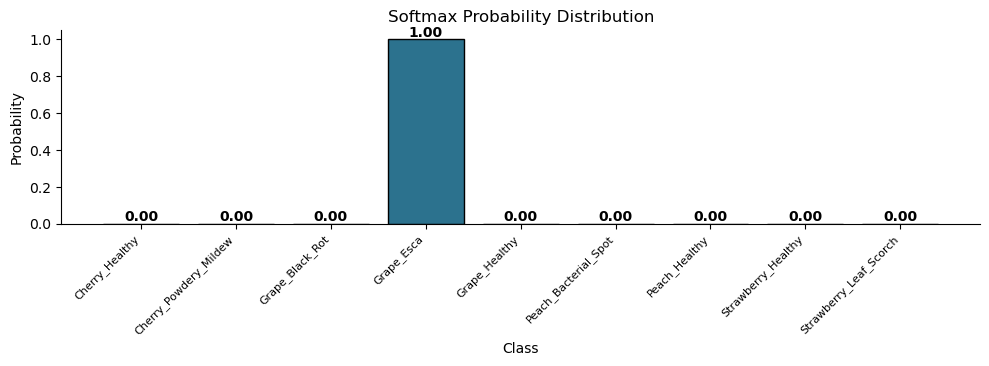

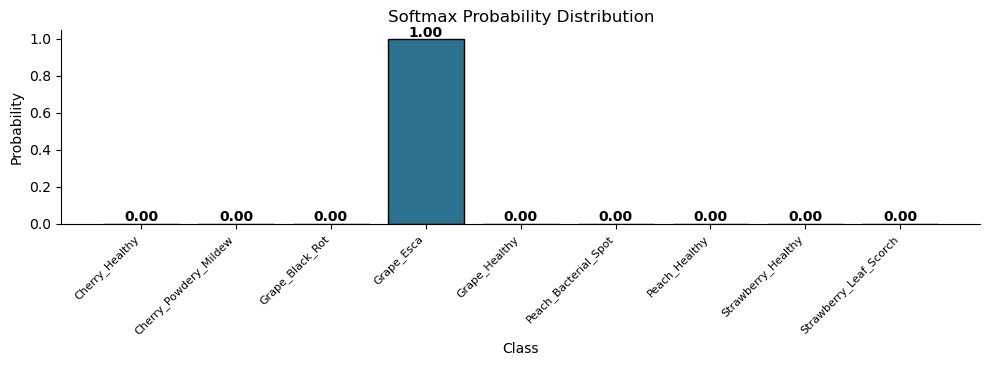

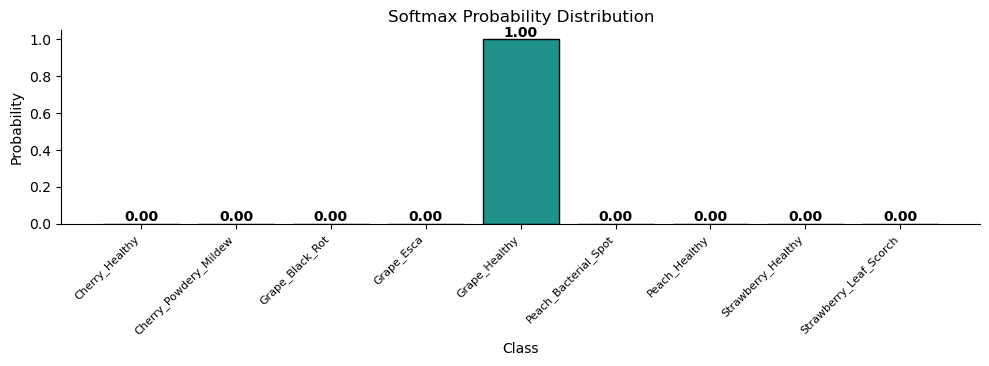

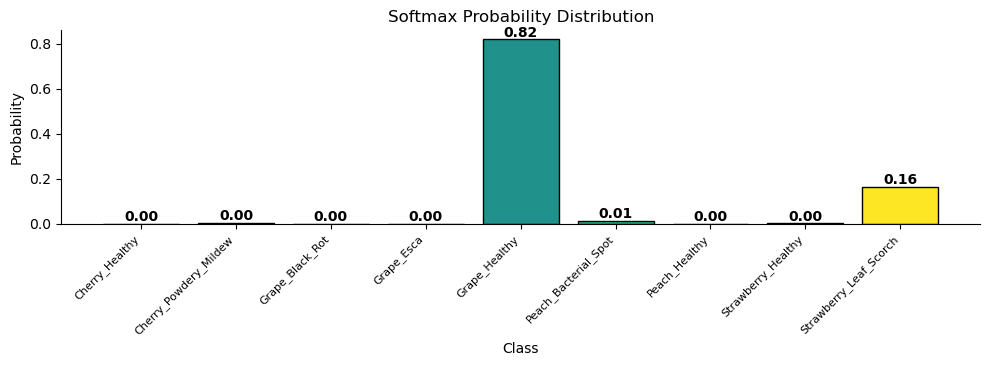

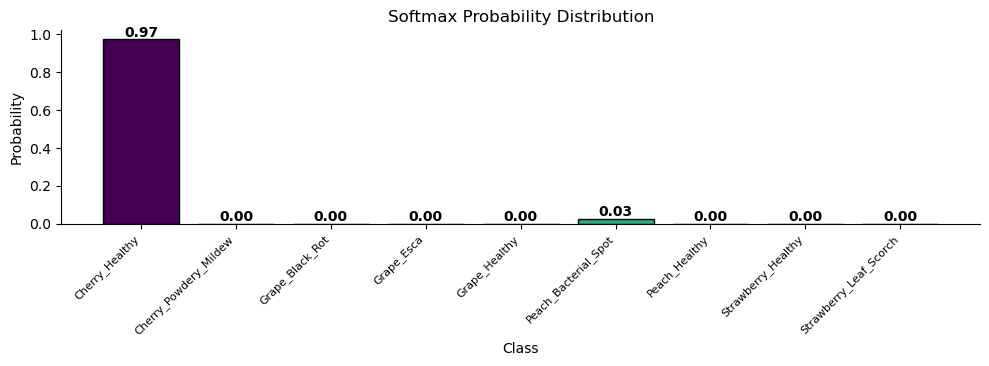

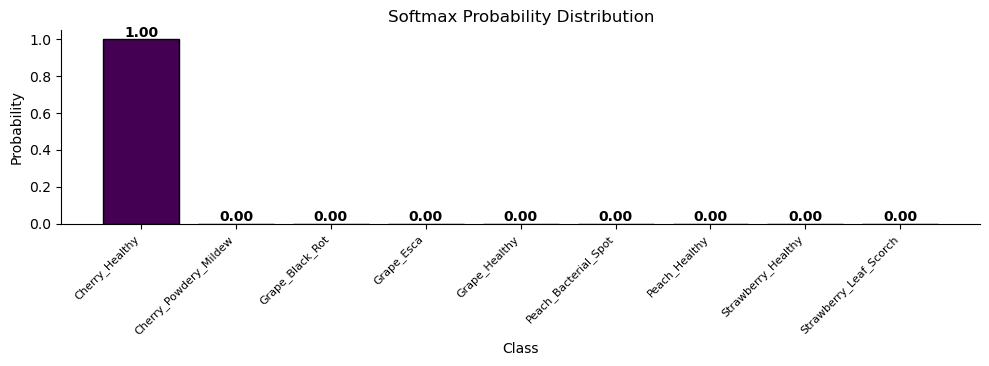

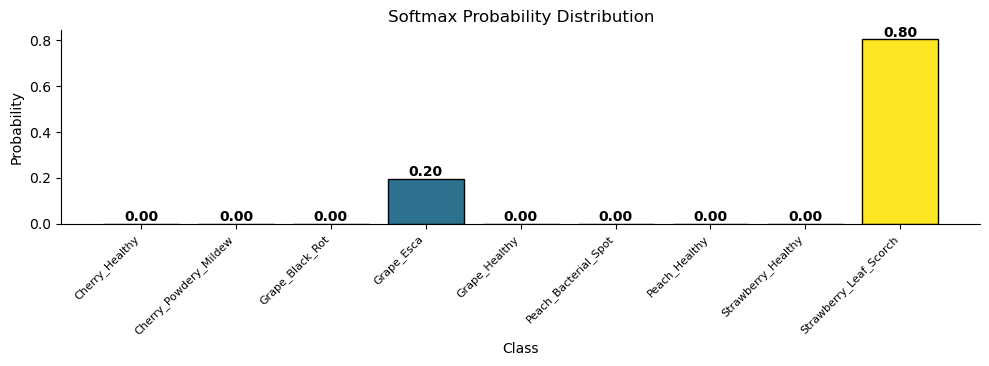

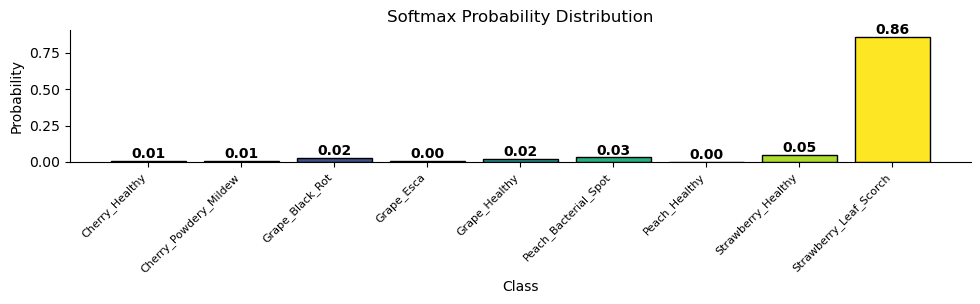

In [1]:
# Importing all the required libraries for the GUI
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.models import load_model
import os
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

accuracy_cnn = 83.33
accuracy_tf = 88.89

# Loading the saved classification models
cnn_model = load_model('cnn_plant_disease_classifier.h5')
transfer_learning_model = load_model('tl_plant_disease_classifier.h5')

# Defining the class labels and mapping
class_indices = {'Cherry_Healthy': 0, 'Cherry_Powdery_Mildew': 1, 'Grape_Black_Rot': 2, 
                 'Grape_Esca': 3, 'Grape_Healthy': 4, 'Peach_Bacterial_Spot': 5, 
                 'Peach_Healthy': 6, 'Strawberry_Healthy': 7, 'Strawberry_Leaf_Scorch': 8}
index_to_class = {v: k for k, v in class_indices.items()}

# Global variables to store the image and its array for prediction
loaded_image = None
img_array = None
true_label = None

def select_image():
    global loaded_image, img_array, photo, true_label
    file_path = filedialog.askopenfilename(initialdir="/", title="Choose an image",
                                            filetypes=(("jpeg files", "*.jpg"), ("all files", "*.*")))
    if file_path:
        image = Image.open(file_path)
        
        # Resizing the image to a smaller size for display
        display_size = (150, 150)  
        display_image = image.resize(display_size)
        photo = ImageTk.PhotoImage(display_image)

        image_label.configure(image=photo)
        image_label.image = photo  

        # Resizing the image to match the model's input shape for prediction
        model_input_size = (256, 256)
        model_input_image = image.resize(model_input_size)
        
        # Converting image to array and store for prediction
        img_array = np.array(model_input_image) / 255.0
        img_array = np.expand_dims(img_array, axis=0) 

        # Resetting the predicted label text
        predicted_label_text.set("")
        warn_label_text.set("")
        healthy_label_text.set("")

        # Enabling the predict buttons
        cnn_button.config(state=tk.NORMAL)
        tf_button.config(state=tk.NORMAL)

# Defining function for predicting with the models
def predict_with_model(model):
    global img_array
    if img_array is not None:
        try:
            predictions = model.predict(img_array)
            predicted_class = index_to_class[np.argmax(predictions)]
            return predicted_class, predictions
        except Exception as e:
            print(f"Error in prediction- {e}")
            return None, None
    else:
        messagebox.showwarning("Warning", "Please load an image first.")

# Plotting the Softmax Probability Distribution Graph
def display_plot(predictions):
    class_labels = list(class_indices.keys())
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(class_labels)))

    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(range(len(class_labels)), predictions[0], color=colors, edgecolor='black', linewidth=1)

    # Customizing the plot
    ax.set_xticks(range(len(class_labels)))
    ax.set_xticklabels(class_labels, rotation=45, ha='right', fontsize=8)
    ax.set_xlabel('Class', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.set_title('Softmax Probability Distribution', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adding labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    fig.tight_layout()

    # Clearing the previous plot if it exists
    if hasattr(window, 'plot_widget'):
        window.plot_widget.pack_forget()

    # Creating a frame for the plot
    plot_frame = tk.Frame(window)
    plot_frame.grid(row=2, column=0, columnspan=2, padx=10, pady=10)

    # Creating a FigureCanvasTkAgg object and add it to the plot frame
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

    # Storing the plot widget as an attribute of the window
    window.plot_widget = canvas.get_tk_widget()

# Defining function for predicting with the CNN Model
def predict_with_cnn():
    predicted_class, predictions = predict_with_model(cnn_model)
    if predicted_class:
        predicted_label = predicted_class.replace("_", " ")
        if "Healthy" not in predicted_label:
            warn_label_text.set("Oops, looks like your plant has a disease!")
            predicted_label_text.set("Prediction by CNN Model- " + predicted_label)
        else:
            healthy_label_text.set("Your plant looks perfectly healthy!")
            predicted_label_text.set("Prediction by CNN Model- " + predicted_label)
        display_plot(predictions)

# Defining function for predicting with the Tranfer Learning Model
def predict_with_transfer_learning():
    predicted_class, predictions = predict_with_model(transfer_learning_model)
    if predicted_class:
        predicted_label = predicted_class.replace("_", " ")
        if "Healthy" not in predicted_label:
            warn_label_text.set("Oops, looks like your plant has a disease!")
            predicted_label_text.set("Prediction by Transfer Learning Model- " + predicted_label)
        else:
            healthy_label_text.set("Your plant looks perfectly healthy!")
            predicted_label_text.set("Prediction by Transfer Learning Model- " + predicted_label)
        display_plot(predictions)

# Creating the main window
window = tk.Tk()
window.title("Plant Disease Detection GUI")
window.geometry("1000x900+300+250")
window.rowconfigure(2, minsize=10, weight=1)
window.columnconfigure(1, minsize=40, weight=1)

# Loading the logo image
logo_image = Image.open("logo.png")
logo_image = logo_image.resize((100, 100))  
logo_photo = ImageTk.PhotoImage(logo_image)

# Creating a frame for the title and logo
title_frame = tk.Frame(window)
title_frame.grid(row=0, column=0, columnspan=2, pady=10)

# Adding title label
title_label = tk.Label(title_frame, text="Plant Disease Detection", font=("Arial", 24), fg="darkgreen")
title_label.pack(side=tk.LEFT, padx=10)

# Creating a label to display the logo image
logo_label = tk.Label(title_frame, image=logo_photo)
logo_label.pack(side=tk.LEFT)

# Creating a frame for input elements
input_frame = tk.Frame(window, bg="floral white", width=200, height=200)
input_frame.grid(row=1, column=0, columnspan=2, padx=10, pady=10)

# Creating a button to select an image
select_button = tk.Button(input_frame, text="Load Image", command=select_image, fg="forestgreen", bg="mediumseagreen", width=15, height=1, font=("Calibri", 15))
select_button.pack(pady=10)

# Creating a label to display the selected image
image_label = tk.Label(input_frame)
image_label.pack()

# Displaying the accuracies of both models
accuracy_label = tk.Label(input_frame, text=f"Test Accuracy of CNN Model = {accuracy_cnn}% | Test Accuracy of Transfer Learning Model = {accuracy_tf}%", font=("Calibri", 16), fg="royalblue", bg="floral white")
accuracy_label.pack(pady=5)

# Modelling selection instruction label
instruction_label = tk.Label(input_frame, text="Please select model to make Prediction", font=("Calibri", 15), fg="mediumpurple", bg="floral white")
instruction_label.pack(pady=10)

# Creating a frame for prediction buttons
button_frame = tk.Frame(input_frame)
button_frame.pack()

# Prediction choice buttons
cnn_button = tk.Button(button_frame, text="Predict with CNN", command=predict_with_cnn, fg="green", bg="cornflowerblue", width=30, height=1, font=("Calibri", 15), state=tk.DISABLED)
cnn_button.pack(side=tk.LEFT, padx=10, pady=10)

tf_button = tk.Button(button_frame, text="Predict with Transfer Learning", command=predict_with_transfer_learning, fg="green", bg="cornflowerblue", width=30, height=1, font=("Calibri", 15), state=tk.DISABLED)
tf_button.pack(side=tk.RIGHT, padx=10, pady=10)

# Creating a label to display the predicted class label
warn_label_text = tk.StringVar()
warn_label_label = tk.Label(input_frame, textvariable=warn_label_text, fg="maroon", font=("Calibri", 16), bg="floral white")
warn_label_label.pack(pady=2)

predicted_label_text = tk.StringVar()
predicted_label_label = tk.Label(input_frame, textvariable=predicted_label_text, fg="teal", font=("Calibri", 18), bg="floral white")
predicted_label_label.pack(pady=2)

healthy_label_text = tk.StringVar()
healthy_label_label = tk.Label(input_frame, textvariable=healthy_label_text, fg="green3", font=("Calibri", 16), bg="floral white")
healthy_label_label.pack(pady=2)

# Running the Tkinter event loop
window.mainloop()